
So last time in file:///Users/michal/Dropbox/Code/repo/restaurant-menu-entities/2023-12-03-menu-entities.html , we looked at paraphrase mining only on a 1000-samples from the full 403,240 set. 

Also lets look at the other dataset here, https://www.kaggle.com/datasets/prashant111/discover-the-menu , maybe there are more dishes in there as opposed to the Kaggle Uber Eats dataset, which had a lot of non food items in there. 

In [6]:
import pandas as pd
import json
from pathlib import Path
from dotenv import dotenv_values
import matplotlib.pyplot as plt
DATA_DIR = dotenv_values()["DATA_DIR"]
HF_TOKEN = dotenv_values()["HF_TOKEN"]

dishdf = pd.read_csv(Path(DATA_DIR) / "kaggle-discover-the-menu/archive/dish.csv")

metadata = json.loads((Path(DATA_DIR) / "kaggle-discover-the-menu/archive/datapackage.json").read_text())

In [7]:
metadata

{'name': 'data-society_discover-the-menu',
 'title': 'Discover The Menu',
 'description': "Data includes 45,000 menus from the 1840s to the present.\n\n## Data generated through NYPL's crowdsourcing project *What's on the menu?*\n\nHere you will find The New York Public Library's transcribed historical restaurant menus, dish by dish, so that they can be searched by what people were eating back in the day. With approximately 45,000 menus dating from the 1840s to the present, The New York Public Library’s restaurant menu collection is one of the largest in the world, used by historians, chefs, novelists and everyday food enthusiasts. \n\nThe New York Public Library’s menu collection, housed in the Rare Book Division, originated through the energetic efforts of Miss Frank E. Buttolph (1850-1924), who, in 1900, began to collect menus on the Library's behalf. Miss Buttolph added more than 25,000 menus to the collection, before leaving the Library in 1924. The collection has continued to gro

In [8]:
dishdf.shape

(426740, 9)

In [10]:
dishdf.sample(n=10).head()

,id,name,description,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
142375,178179,"Gin Fizz - Gordon's Dry Gin, Zitrone, Zucker, ...",NaN,1,1,0,0,0.00,0.00
71908,90540,"Alose au beurre, ravigote",NaN,1,1,1884,1884,0.00,0.00
246829,312157,Pernod Cordial,NaN,1,1,1947,1947,0.75,1.00
148643,186154,Vanilla Ice Cream with Pound Cake,NaN,3,3,1937,1946,0.20,0.35
425777,518094,"Asperges Nouvelles, Sauce Hollandaise",NaN,1,1,0,0,0.00,0.00


## When are these dishes from? 

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

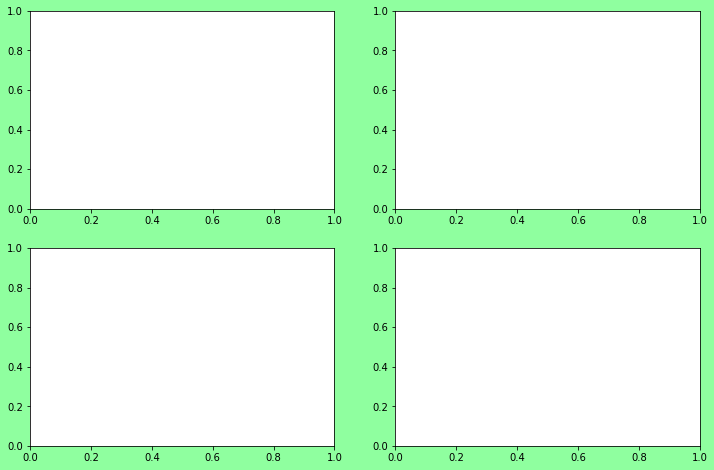

In [18]:
fig, axes = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
fig.patch.set_facecolor("xkcd:mint green")
ax = axes[0]
ax.hist(dishdf[dishdf.first_appeared > 1]["first_appeared"], bins=50, alpha=0.2)
ax.set(title="all time")

ax = axes[1]
ax.hist(dishdf[dishdf.last_appeared > 1]["last_appeared"], bins=50, alpha=0.2)
ax.set(title="After 1990")

ax = axes[2]
ax.hist(dishdf[(dishdf.first_appeared > 1990)]["first_appeared"], bins=50, alpha=0.2)
ax.set(title="all time")

ax = axes[3]
ax.hist(dishdf[dishdf.last_appeared > 1990]["last_appeared"], bins=50, alpha=0.2)
ax.set(title="After 1990")

fig.show()